In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Dataset/AffectNetHQ.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydataset')

In [20]:
image_size=(224,224)
transform_train = transforms.Compose([
     transforms.ToTensor()
])

transform_test = transforms.Compose([
     transforms.ToTensor()
])

In [21]:
train_dataset = datasets.ImageFolder(root='/content/mydataset/AffectNetHQ/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/content/mydataset/AffectNetHQ/validation', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/content/mydataset/AffectNetHQ/test', transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True, drop_last=False,num_workers=4)
val_loader = DataLoader(train_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)

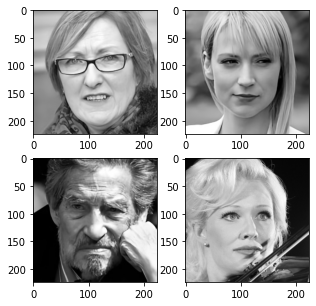

In [22]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

plot_data_loader(train_loader, (2, 2))

In [23]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Number of classes: 8
Train Size: 6400
Test Size: 2000
Validation Size: 1600


In [24]:
torch.cuda.empty_cache()

In [25]:
model = models.shufflenet_v2_x1_0(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


In [26]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 30
for epoch in range(num_epochs):
 
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    

    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    lr_sched.step()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            pbar.update(1)


Epoch 1/30 | Train Loss: 1.9773 | Train Acc: 0.1889 | Val Loss: 2.0529 | Val Acc: 0.2039


Epoch 1/30: 100%|██████████| 50/50 [00:04<00:00, 10.87batch/s]


Epoch 2/30 | Train Loss: 1.7258 | Train Acc: 0.2678 | Val Loss: 1.5883 | Val Acc: 0.3202


Epoch 2/30: 100%|██████████| 50/50 [00:04<00:00, 10.88batch/s]


Epoch 3/30 | Train Loss: 1.5113 | Train Acc: 0.3670 | Val Loss: 1.4421 | Val Acc: 0.4177


Epoch 3/30: 100%|██████████| 50/50 [00:04<00:00, 10.87batch/s]


Epoch 4/30 | Train Loss: 1.3852 | Train Acc: 0.4467 | Val Loss: 1.2412 | Val Acc: 0.5169


Epoch 4/30: 100%|██████████| 50/50 [00:04<00:00, 10.84batch/s]


Epoch 5/30 | Train Loss: 1.2395 | Train Acc: 0.5056 | Val Loss: 1.0970 | Val Acc: 0.5603


Epoch 5/30: 100%|██████████| 50/50 [00:04<00:00, 10.91batch/s]


Epoch 6/30 | Train Loss: 1.1037 | Train Acc: 0.5586 | Val Loss: 0.9364 | Val Acc: 0.6302


Epoch 6/30: 100%|██████████| 50/50 [00:04<00:00, 11.03batch/s]


Epoch 7/30 | Train Loss: 0.9711 | Train Acc: 0.6109 | Val Loss: 0.6952 | Val Acc: 0.7400


Epoch 7/30: 100%|██████████| 50/50 [00:04<00:00, 10.82batch/s]


Epoch 8/30 | Train Loss: 0.4820 | Train Acc: 0.8556 | Val Loss: 0.3694 | Val Acc: 0.9086


Epoch 8/30: 100%|██████████| 50/50 [00:04<00:00, 10.91batch/s]


Epoch 9/30 | Train Loss: 0.2942 | Train Acc: 0.9367 | Val Loss: 0.2070 | Val Acc: 0.9653


Epoch 9/30: 100%|██████████| 50/50 [00:04<00:00, 10.87batch/s]


Epoch 10/30 | Train Loss: 0.1651 | Train Acc: 0.9766 | Val Loss: 0.1023 | Val Acc: 0.9908


Epoch 10/30: 100%|██████████| 50/50 [00:04<00:00, 10.95batch/s]


Epoch 11/30 | Train Loss: 0.0965 | Train Acc: 0.9888 | Val Loss: 0.0517 | Val Acc: 0.9967


Epoch 11/30: 100%|██████████| 50/50 [00:04<00:00, 10.88batch/s]


Epoch 12/30 | Train Loss: 0.0598 | Train Acc: 0.9961 | Val Loss: 0.0308 | Val Acc: 0.9983


Epoch 12/30: 100%|██████████| 50/50 [00:04<00:00, 10.81batch/s]


Epoch 13/30 | Train Loss: 0.0384 | Train Acc: 0.9977 | Val Loss: 0.0203 | Val Acc: 0.9988


Epoch 13/30: 100%|██████████| 50/50 [00:04<00:00, 10.90batch/s]


Epoch 14/30 | Train Loss: 0.0294 | Train Acc: 0.9980 | Val Loss: 0.0150 | Val Acc: 0.9988


Epoch 14/30: 100%|██████████| 50/50 [00:04<00:00, 10.87batch/s]


Epoch 15/30 | Train Loss: 0.0280 | Train Acc: 0.9966 | Val Loss: 0.0143 | Val Acc: 0.9988


Epoch 15/30: 100%|██████████| 50/50 [00:04<00:00, 10.81batch/s]


Epoch 16/30 | Train Loss: 0.0218 | Train Acc: 0.9984 | Val Loss: 0.0140 | Val Acc: 0.9988


Epoch 16/30: 100%|██████████| 50/50 [00:04<00:00, 10.66batch/s]


Epoch 17/30 | Train Loss: 0.0232 | Train Acc: 0.9977 | Val Loss: 0.0131 | Val Acc: 0.9988


Epoch 17/30: 100%|██████████| 50/50 [00:04<00:00, 10.84batch/s]


Epoch 18/30 | Train Loss: 0.0221 | Train Acc: 0.9980 | Val Loss: 0.0126 | Val Acc: 0.9988


Epoch 18/30: 100%|██████████| 50/50 [00:04<00:00, 10.56batch/s]


Epoch 19/30 | Train Loss: 0.0218 | Train Acc: 0.9978 | Val Loss: 0.0123 | Val Acc: 0.9986


Epoch 19/30: 100%|██████████| 50/50 [00:04<00:00, 10.31batch/s]


Epoch 20/30 | Train Loss: 0.0206 | Train Acc: 0.9986 | Val Loss: 0.0118 | Val Acc: 0.9988


Epoch 20/30: 100%|██████████| 50/50 [00:04<00:00, 10.27batch/s]


Epoch 21/30 | Train Loss: 0.0188 | Train Acc: 0.9988 | Val Loss: 0.0115 | Val Acc: 0.9988


Epoch 21/30: 100%|██████████| 50/50 [00:04<00:00, 10.82batch/s]


Epoch 22/30 | Train Loss: 0.0189 | Train Acc: 0.9986 | Val Loss: 0.0117 | Val Acc: 0.9988


Epoch 22/30: 100%|██████████| 50/50 [00:04<00:00, 10.96batch/s]


Epoch 23/30 | Train Loss: 0.0195 | Train Acc: 0.9988 | Val Loss: 0.0113 | Val Acc: 0.9989


Epoch 23/30: 100%|██████████| 50/50 [00:04<00:00, 10.82batch/s]


Epoch 24/30 | Train Loss: 0.0200 | Train Acc: 0.9980 | Val Loss: 0.0112 | Val Acc: 0.9988


Epoch 24/30: 100%|██████████| 50/50 [00:04<00:00, 10.79batch/s]


Epoch 25/30 | Train Loss: 0.0188 | Train Acc: 0.9988 | Val Loss: 0.0113 | Val Acc: 0.9988


Epoch 25/30: 100%|██████████| 50/50 [00:04<00:00, 10.91batch/s]


Epoch 26/30 | Train Loss: 0.0228 | Train Acc: 0.9970 | Val Loss: 0.0110 | Val Acc: 0.9988


Epoch 26/30: 100%|██████████| 50/50 [00:04<00:00, 10.84batch/s]


Epoch 27/30 | Train Loss: 0.0198 | Train Acc: 0.9981 | Val Loss: 0.0110 | Val Acc: 0.9991


Epoch 27/30: 100%|██████████| 50/50 [00:04<00:00, 10.90batch/s]


Epoch 28/30 | Train Loss: 0.0179 | Train Acc: 0.9986 | Val Loss: 0.0111 | Val Acc: 0.9989


Epoch 28/30: 100%|██████████| 50/50 [00:04<00:00, 10.92batch/s]


Epoch 29/30 | Train Loss: 0.0187 | Train Acc: 0.9989 | Val Loss: 0.0109 | Val Acc: 0.9988


Epoch 29/30: 100%|██████████| 50/50 [00:04<00:00, 10.77batch/s]


Epoch 30/30 | Train Loss: 0.0204 | Train Acc: 0.9984 | Val Loss: 0.0111 | Val Acc: 0.9989


Epoch 30/30: 100%|██████████| 50/50 [00:04<00:00, 11.02batch/s]


In [31]:
val_accs = torch.tensor(val_accs)
train_accs=torch.tensor(train_accs)

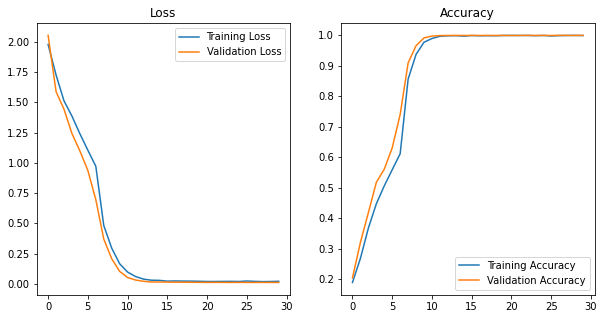

In [28]:
train_accs = [acc.item() for acc in train_accs]
val_accs = torch.tensor(val_accs)  
test_accs = [acc.item() for acc in val_accs]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


Test Accuracy of the model on the 2000 test images: 42.15 %


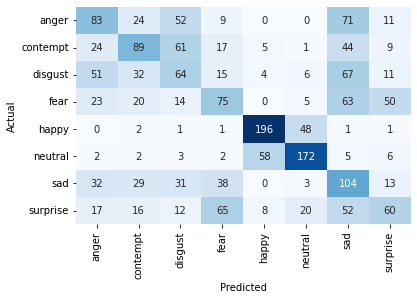

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


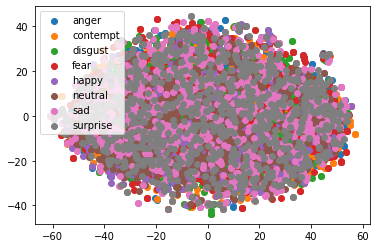

In [30]:
import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

label_names = ['anger', 'contempt', 'disgust','fear','happy','neutral','sad','surprise']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

shufflenet = models.shufflenet_v2_x1_0(pretrained=False)

shufflenet = torch.nn.Sequential(*list(shufflenet.children())[:-1])

shufflenet.eval()


features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        outputs = shufflenet(images)
        features.append(outputs.view(outputs.size(0), -1).numpy())
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()